In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pyLDAvis
import random
import scipy.sparse
import sys
import time

from gensim.models.coherencemodel import CoherenceModel
from pyspark import SparkContext
from pyspark.sql import SparkSession
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

/home/olam/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
class FakedGensimDict:
    """
    Locally made class for `~gensim.corpora.dictionary.Dictionary`
    """
    def __init__(self, data, S):
        if not isinstance(data, dict):
            raise ValueError('`data` must be an instance of `dict`')

        self.id2token = data
        self.token2id = {v: k for k, v in data.items()}
        self.doc2bow = S

    @staticmethod
    def from_vocab(vocab):
        return FakedGensimDict(dict(zip(range(len(vocab)), vocab)))

In [3]:
conf = SparkConf().setMaster("local").setAll([
     ('spark.executor.memory', '8g'),
     ('spark.driver.memory','8g'),
     ('spark.driver.maxResultSize', '0')
    ])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

/home/olam/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:75: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
def remove_zero_rows(M):
    '''Function that removes all rows from sparse matrix M that contains only zero.'''
    num_nonzeros = np.diff(M.indptr)
    return M[num_nonzeros != 0]

In [5]:
# Load data
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/view10000_sub100000/csr_matrices_100000sub/S_final_tok100vid.npz')

# Load set of videos to consider
with open('/dlabdata1/youtube_large/olam/data/view10000_sub100000/sorted_idx_relevant_vid_top20_sub100000.pickle', 'rb') as f:
    sorted_idx_relevant_vid_top20 = pickle.load(f)
f.close()

S_20 = S[sorted_idx_relevant_vid_top20,:]
S_20 = remove_zero_rows(S_20)

In [6]:
# Load dictionnary of words
with open('/dlabdata1/youtube_large/olam/data/view10000_sub100000/id2word_tok100vid_sub100000.pickle', 'rb') as f:
    id2word = pickle.load(f)
f.close()

In [ ]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/view10000_sub100000/LDA_models/top20/describe_topics_75_iter1000_tok100vid.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

## Computing c_v coherence of a topic model

In [ ]:
topics = []

for row in describe_topics.sort('topic').rdd.collect():
    tokenized_topic = []
    for i, token_id in enumerate(row.termIndices):
        tokenized_topic.append(id2word[token_id])
        if i > 5:
            break
    topics.append(tokenized_topic)

In [ ]:
describe_topics = describe_topics.sort('topic')

In [ ]:
vocabSize = S_20.shape[1]

In [ ]:
topic_word_dist = []

for row in describe_topics.collect():
    termIndices = row['termIndices']
    termWeights = row['termWeights']
    
    word_dist = {}
    for i in range(vocabSize):
        word_dist[termIndices[i]] = termWeights[i]
        
    word_dist_ordered = collections.OrderedDict(sorted(word_dist.items()))
    topic_word_dist.append(list(word_dist_ordered.values()))

In [ ]:
topic_word_dist = np.matrix(topic_word_dist)

In [ ]:
vocab = list(id2word.values())

In [ ]:
vocab = np.array(vocab)

In [ ]:
texts = []

In [ ]:
for i in range(S_20.shape[0]):
    token_indices = list(S_20.getrow(i).nonzero()[1])
    tokens = []
    
    for token_indice in token_indices:
        tokens.append(id2word[token_indice])
    texts.append(tokens)

In [ ]:
topic_word_dist.shape

In [ ]:
coherence_score = metric_coherence_gensim(measure='c_v',
                                          topic_word_distrib=topic_word_dist,
                                          vocab=vocab,
                                          texts=texts)

In [ ]:
coherence_model = CoherenceModel(topics=topics,
                                 corpus=S_20,
                                 dictionary=FakedGensimDict.from_vocab(vocab),
                                 texts=texts,
                                 coherence='c_v')

In [ ]:
coherence_model.get_coherence() ## with 5 words to describe topics

In [ ]:
coherence_model.get_coherence() ## with 10 words to describe topics

In [ ]:
coherence_model.get_coherence() ## with 20 words to describe topics

## Get coherence scores from multiple models to choose optimal number of topics

In [7]:
texts = []

for i in range(S_20.shape[0]):
    token_indices = list(S_20.getrow(i).nonzero()[1])
    tokens = []
    
    for token_indice in token_indices:
        tokens.append(id2word[token_indice])
    texts.append(tokens)

In [8]:
corpus = []

for row in S_20.toarray():
    bow = []
    idx_nonzero = np.nonzero(row)[0]
    for i in range(len(idx_nonzero)):
        bow.append((idx_nonzero[i], row[idx_nonzero[i]]))
    corpus.append(bow)

In [44]:
coherence_scores = []
coherence_scores_umass = []

n_topics_list = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 
                 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160]

for i, n_topics in enumerate(n_topics_list):
    
    print('Computing coherence score for model with ' + str(n_topics) + ' topics...')
    
    # Get describe_topics dataframe
    describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/view10000_sub100000/LDA_models/top20/tune/describe_topics_' + str(n_topics) + '_iter1000_tok100vid.json')
    
    
    # Characterize the topics with tokens
    topics = []

    for row in describe_topics.sort('topic').rdd.collect():
        tokenized_topic = []
        for j, token_id in enumerate(row.termIndices):
            tokenized_topic.append(id2word[token_id])
            if j > 10:
                break
        topics.append(tokenized_topic)
        
    # Compute c_v coherence score and append to coherence scores
    coherence_model = CoherenceModel(topics=topics,
                                     corpus=S_20,
                                     dictionary=FakedGensimDict(id2word, S_20),
                                     texts=texts,
                                     coherence='c_v')
    
    # Compute u_mass coherence score and append to coherence scores
    coherence_model_umass = CoherenceModel(topics=topics,
                                     corpus=corpus,
                                     dictionary=FakedGensimDict(id2word, S_20),
                                     coherence='u_mass')
     
    print('Getting c_v coherence score...')
    coherence_scores.append(coherence_model.get_coherence())
    print('Getting u_mass coherence score...')
    coherence_scores_umass.append(coherence_model_umass.get_coherence())
    print('')

Computing coherence score for model with 40 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 45 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 50 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 55 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 60 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 65 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 70 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with 75 topics...
Getting c_v coherence score...
Getting u_mass coherence score...

Computing coherence score for model with

([<matplotlib.axis.XTick at 0x7fdacc6dd310>,
 [Text(0, 0, '40'),
  Text(1, 0, '45'),
  Text(2, 0, '50'),
  Text(3, 0, '55'),
  Text(4, 0, '60'),
  Text(5, 0, '65'),
  Text(6, 0, '70'),
  Text(7, 0, '75'),
  Text(8, 0, '80'),
  Text(9, 0, '85'),
  Text(10, 0, '90'),
  Text(11, 0, '95'),
  Text(12, 0, '100'),
  Text(13, 0, '105'),
  Text(14, 0, '110'),
  Text(15, 0, '115'),
  Text(16, 0, '120'),
  Text(17, 0, '125'),
  Text(18, 0, '130'),
  Text(19, 0, '135'),
  Text(20, 0, '140'),
  Text(21, 0, '145'),
  Text(22, 0, '150'),
  Text(23, 0, '155'),
  Text(24, 0, '160')])

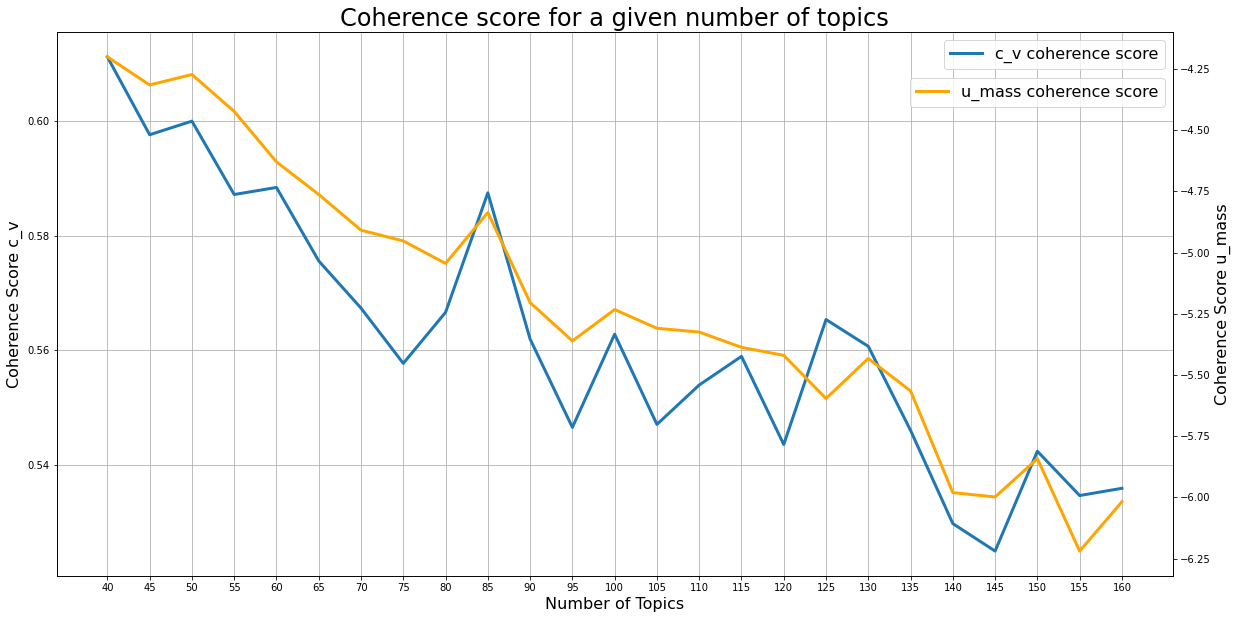

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Coherence score for a given number of topics', fontsize=24)
ax.set_xlabel('Number of Topics', fontsize=16)
ax.set_ylabel('Coherence Score c_v', fontsize=16)

ax.grid('on')

ax.plot(coherence_scores, label='c_v coherence score', linewidth=3)

ax2 = ax.twinx()
ax2.set_ylabel('Coherence Score u_mass', fontsize=16)
ax2.plot(coherence_scores_umass, label='u_mass coherence score', linewidth=3, color='orange')

ax.legend(fontsize=16)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.93), fontsize=16)

plt.xticks(np.arange(len(n_topics_list)), n_topics_list)

In [46]:
fig.savefig('/home/olam/coherence_scores')

In [7]:
def is_corpus(obj):
    """Check whether `obj` is a corpus, by peeking at its first element. Works even on streamed generators.
    The peeked element is put back into a object returned by this function, so always use
    that returned object instead of the original `obj`.
    Parameters
    ----------
    obj : object
        An `iterable of iterable` that contains (int, numeric).
    Returns
    -------
    (bool, object)
        Pair of (is `obj` a corpus, `obj` with peeked element restored)
    Examples
    --------
    .. sourcecode:: pycon
        >>> from gensim.utils import is_corpus
        >>> corpus = [[(1, 1.0)], [(2, -0.3), (3, 0.12)]]
        >>> corpus_or_not, corpus = is_corpus(corpus)
    Warnings
    --------
    An "empty" corpus (empty input sequence) is ambiguous, so in this case
    the result is forcefully defined as (False, `obj`).
    """
    try:
        if 'Corpus' in obj.__class__.__name__:  # the most common case, quick hack
            return True, obj
    except Exception:
        pass
    try:
        if hasattr(obj, 'next') or hasattr(obj, '__next__'):
            # the input is an iterator object, meaning once we call next()
            # that element could be gone forever. we must be careful to put
            # whatever we retrieve back again
            doc1 = next(obj)
            obj = itertools.chain([doc1], obj)
        else:
            doc1 = next(iter(obj))  # empty corpus is resolved to False here
        if len(doc1) == 0:  # sparse documents must have a __len__ function (list, tuple...)
            return True, obj  # the first document is empty=>assume this is a corpus

        # if obj is a 1D numpy array(scalars) instead of 2-tuples, it resolves to False here
        id1, val1 = next(iter(doc1))
        id1, val1 = int(id1), float(val1)  # must be a 2-tuple (integer, float)
    except Exception:
        return False, obj
    return True, obj


In [33]:
corpus_test = [
    [(1, 1), (2, 5), (5, 2)],
    [(0, 2), (2, 3), (4, 1)],
    [(1, 3), (3, 2), (4, 1)]
]

In [34]:
is_corpus(corpus_test)

(True,
 [[(1, 1), (2, 5), (5, 2)],
  [(0, 2), (2, 3), (4, 1)],
  [(1, 3), (3, 2), (4, 1)]])